# Programming Assignment 1: MNIST

## PACKAGE IMPLEMENTATION

Download the necessary libraries

In [1]:
# Import the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # used for one hot encoding

## DATA LOADING AND DATA PREPARATION

Here the GPU can be used since it is computed with Torch.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Get the training and testing datasets
# First need to transform the images into a suitable form (normalization) and convert them to a Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])

# DataLoader class
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainset, valset = random_split(trainset, [50000, 10000])

dataloaders = {}
# First I import the "full" dataset without dividing it into batches. I'll do it during the training of the model
dataloaders['train'] = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
dataloaders['validation'] = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(testset, len(testset), shuffle=False)

# train_features, train_labels = next(iter(dataloaders['train']))
test_features, test_labels = next(iter(dataloaders['test']))
test_features = test_features.to(device)
test_labels = test_labels.to(device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1969116.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 426860.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3929662.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4927710.49it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## CHECKS

In [4]:
ds_type = 'validation'
for images, labels in dataloaders[ds_type]:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


##  CONFIGURING THE CONVNET

In [5]:
# in_channels = 1 --> they are not RGB images
# num_classes = 10 --> one-hot encoding
class MyCNN(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):
    super(MyCNN,self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(
                                  in_channels=in_channels,
                                  out_channels=32,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1,
                                  padding_mode='zeros'))

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(nn.Conv2d(
                                  in_channels=32,
                                  out_channels=32,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1,
                                  padding_mode='zeros'))
    self.fc1 = nn.Sequential(nn.Linear(in_features=32*7*7, out_features=500))

    self.fc2 = nn.Linear(in_features=500, out_features=num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1) # need to reshape to feed the FC layer
    x = F.relu(self.fc1(x))
    # Output layer: CrossEntropyLoss() already combines softmax and loss
    x = self.fc2(x)
    return x

In [6]:
model = MyCNN().to(device)
print(model)

MyCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=1568, out_features=500, bias=True)
  )
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


## TRAIN THE MODEL

In [7]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs=5, device='cpu'):
    """
    Train the model given the data. For num_epochs of time the model is trained, which
    means that, based on the backward propagation, the weights (params) are adjusted.
    The loss function is also saved so to understand if the model is actually learning well.
    :param:
    model: desired network to be trained
    dataloader: torch loader of the training data (inputs and labels)
    loss_fn: loss function to use during the training of the network
    optimizer: optimizer to use during the training of the network
    num_epochs: for how many epochs the model will be trained?
    device: in this case just cpu is available since I'm working with numpy

    :return:
    train_loss: list of loss every 200 iterations (i.e 200 batch updates)
    epoch_loss: list of loss function for every epoch (in total num_epochs values)
    validation_accuracy: accuracy of the model on the training data
    validation_loss: list of loss function every 200 iterations on ALL the test data
    """
    model.train()

    num_batches = len(dataloader)
    train_loss, epoch_loss, validation_loss, validation_accuracy = [],[],[],[]

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_batch = 0

        for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)

          # Forward pass
          outputs = model(inputs)

          # Calculate the loss
          loss = loss_fn(outputs, labels)
          running_loss += loss.item() * inputs.size(0)

          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_batch += 1

          if running_batch % 200 == 0:
            model.eval()

            with torch.no_grad():
              correct, total = 0,0
              for images,labels in dataloaders['validation']:
                images, labels = images.to(device), labels.to(device)
                preds = model(images)
                val_loss = loss_fn(preds,labels)
                # skip the max actual value, I need the index
                _,pred = torch.max(preds.data,1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
              train_loss.append(loss.item())
              validation_accuracy.append(correct/total)
              validation_loss.append(val_loss.item())

        epoch_loss.append(running_loss/len(dataloader.dataset))
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss[-1]:.4f}')

    return train_loss, epoch_loss, validation_loss, validation_accuracy

In [8]:
# Initialize the model, criterion, and optimizer
learning_rate = 3e-4 # karpathy's constant
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_loss, epoch_loss, validation_loss, validation_accuracy = train_model(model, dataloaders['train'], criterion, optimizer, num_epochs=5, device=device)

Epoch [1/5], Loss: 0.2240
Epoch [2/5], Loss: 0.0627
Epoch [3/5], Loss: 0.0421
Epoch [4/5], Loss: 0.0315
Epoch [5/5], Loss: 0.0247


## POINT 1.a
Show the plot of training error, validation error and prediction accuracy as the training progresses

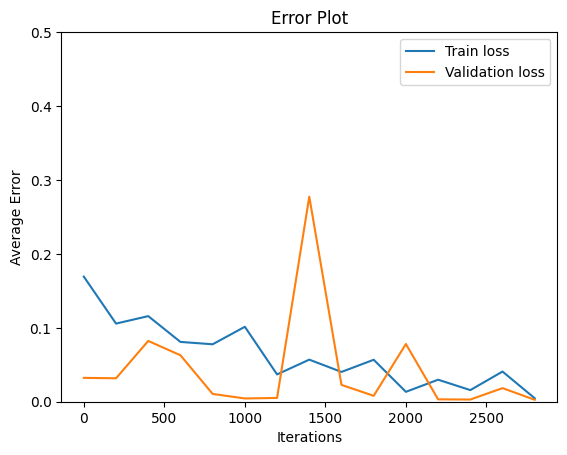

In [9]:
# Show the Loss function: I can understand if the model actually learned something
x = 200*np.arange(0, len(train_loss))
plt.ylim(0,0.5)
plt.plot(x,train_loss, label='Train loss')
plt.plot(x,validation_loss, label='Validation loss')
plt.title('Error Plot')
plt.xlabel('Iterations')
plt.ylabel('Average Error')
plt.legend(loc='upper right')
plt.show()

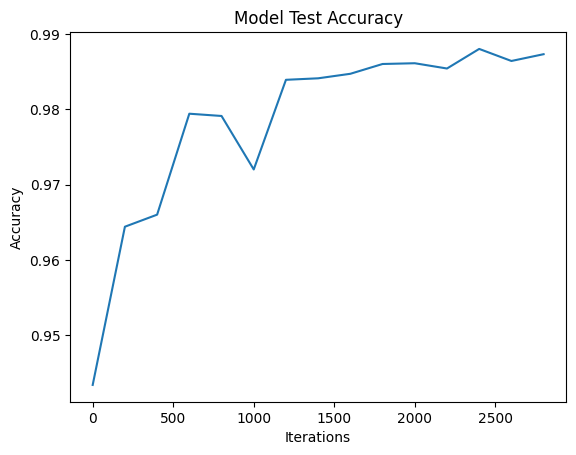

In [10]:
plt.plot(x, validation_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Test Accuracy')

plt.show()

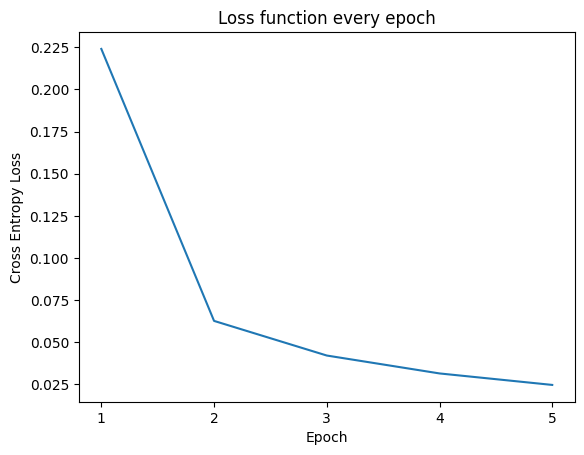

In [11]:
plt.plot(range(1,len(epoch_loss)+1), epoch_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xticks(np.arange(1, 6, 1))
plt.title('Loss function every epoch')
plt.show()

## POINT 1.b
At the end of training, report the average prediction accuracy for the whole test set of 10000 images.

In [13]:
def evaluate_model(model, dataloader, device='cpu'):
  """
  No return. Just print the accuracy of model in the given test dataset.
  :param:
  model: desired network to be tested
  dataloader: torch loader of the test data (inputs and labels)

  :return:
  """
  misclassified = 0
  total = len(dataloader.sampler)

  # Set the model to evaluation mode
  model.eval()

  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to("cpu") # need to put labels into cpu to make the computation
      test_labels_onehot_p = model(inputs.float())
      test_labels_p = np.argmax(test_labels_onehot_p.detach().cpu().numpy(), axis=1)
      misclassified += np.count_nonzero(labels-test_labels_p)

  accuracy = 1 - misclassified / total
  print('Accuracy on validation set: {:.2f}%'.format(100 * accuracy))

In [14]:
# Evaluate the model on the test data
evaluate_model(model, dataloaders['test'], device=device)

Accuracy on validation set: 98.74%


## POINT 2
Plot randomly selected test images showing the true and predicted class labels.

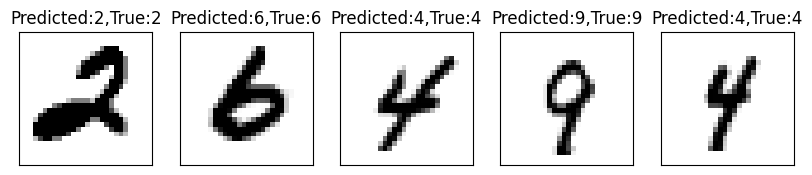

In [16]:
test_features, test_labels = next(iter(dataloaders['test']))
# Depict some pictures from the training set
plt.figure(figsize=(10,10))

# Get a random value, index from which get the digits
rnd_value = int(len(test_labels) * torch.rand(1).item())
img, labels = test_features[rnd_value:rnd_value+5,], test_labels[rnd_value:rnd_value+5,]
img, labels = img.to(device), labels.to(device)

# Get the prediction
test_pred = model(img)
y_preds = torch.max(test_pred.data,1)[1].cpu().numpy()

#print(labels)
#print(y_preds)

# Plot
for i in range(len(y_preds)):
    plt.subplot(5,5,i+1)
    plt.title(f'Predicted:{y_preds[i]},True:{labels.data[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Convert the image to a format suitable for plotting
    plt.imshow(img[i].cpu().squeeze().numpy(), cmap=plt.cm.binary)

plt.show()

## POINT 3-4-5
3. Report the dimensions of the input and output at each layer.
4. How many parameters does your network have? How many of these are in the fully connected layers and how many are in the convolutional layers?

In [17]:
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           9,248
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 500]         784,500
            Linear-6                   [-1, 10]           5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 3.05
Estimated Total Size (MB): 3.35
----------------------------------------------------------------


| Layer    | Input </br>dimension | Output </br>Dimensions | Param # |Notes |
|:---------|:--------:|---------:|---------:|---------:|
|  Input    |  (1, 28, 28)   |  (1, 28, 28)   |  -   |  Image 28x28   |
|  Conv2d-1    |  (1, 28, 28)   |  (32, 28, 28)   |  3x3x32+32=320   |  Application of 32 filter 3x3   |
|  MaxPool2d-2   |  (32, 28, 28)   |  (32, 14, 14)   |  -   |  Pooling has not parameters   |
|  Conv2d-3   |  (32, 14, 14)   |  (32, 14, 14)   |  (3x3x32)x32+32=9248   |  For every 32 feature map I apply 32 filters 3x3   |
|  MaxPool2d-4   |  (32, 14, 14)   |  (32, 7, 7)   |  -   |  Pooling has not parameters   |
|  Linear-5   |  7x7x32=1568   |  500   |  1568x500+500=784500   |  500 is fixed. The feature map is flatten   |
|  Linear-6   |  500   |  10  |  500x10+10=5010  |  Fully connected layer   |

5. How many neurons does your network have? How many of these are in the fully connected layers and how many are in the convolutional layers?

| Layer | # Neurons |
|:---------|:--------:|
|  Conv2d-1   |  32x28x28=25088  |
|  Conv2d-3   |  32x14x14=6272   |
|  Linear-5   |  500   |
|  Linear-6   |  10   |

## POINT 6
 6. Use batch-normalization. Does it improve the test accuracy? Does it affect training time?

In [19]:
class MyCNN_BN(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):
    super(MyCNN_BN,self).__init__()
    self.conv1=nn.Sequential(nn.Conv2d(
                                  in_channels=in_channels,
                                  out_channels=32,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1,
                                  padding_mode='zeros'))

    self.batch_norm = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Sequential(nn.Conv2d(
                                  in_channels=32,
                                  out_channels=32,
                                  kernel_size=3,
                                  stride=1,
                                  padding=1,
                                  padding_mode='zeros'))
    self.fc1 = nn.Sequential(nn.Linear(in_features=32*7*7, out_features=500))

    self.fc2 = nn.Linear(in_features=500, out_features=num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm(x) # batch norm usually before the activation function!
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.batch_norm(x)
    x = F.relu(x)
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1) # need to reshape to feed the FC layer
    x = F.relu(self.fc1(x))
    # Output layer: CrossEntropyLoss() already combines softmax and loss
    x = self.fc2(x)
    return x

In [20]:
model2 = MyCNN_BN().to(device)
print(model2)

MyCNN_BN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=1568, out_features=500, bias=True)
  )
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [21]:
# Initialize the model, criterion, and optimizer
learning_rate = 3e-4 # karpathy's constant
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

# Train the model
train_loss2, epoch_loss2, validation_loss2, validation_accuracy2 = train_model(model2, dataloaders['train'], criterion, optimizer, num_epochs=5, device=device)

Epoch [1/5], Loss: 0.1570
Epoch [2/5], Loss: 0.0468
Epoch [3/5], Loss: 0.0325
Epoch [4/5], Loss: 0.0231
Epoch [5/5], Loss: 0.0178


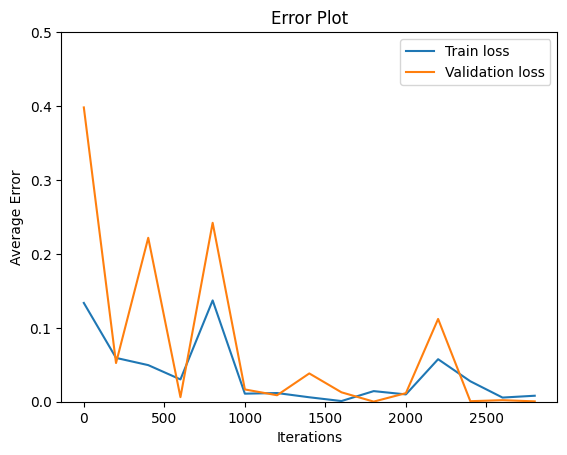

In [22]:
# Show the Loss function: I can understand if the model actually learned something
x = 200*np.arange(0, len(train_loss2))
plt.ylim(0,0.5)
plt.plot(x,train_loss2, label='Train loss')
plt.plot(x,validation_loss2, label='Validation loss')
plt.title('Error Plot')
plt.xlabel('Iterations')
plt.ylabel('Average Error')
plt.legend(loc='upper right')
plt.show()

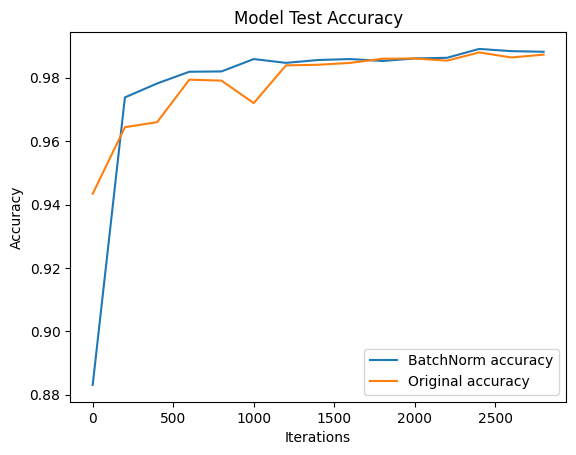

In [23]:
plt.plot(x, validation_accuracy2, label="BatchNorm accuracy")
plt.plot(x, validation_accuracy, label="Original accuracy")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Test Accuracy')
plt.legend(loc='lower right')
plt.show()

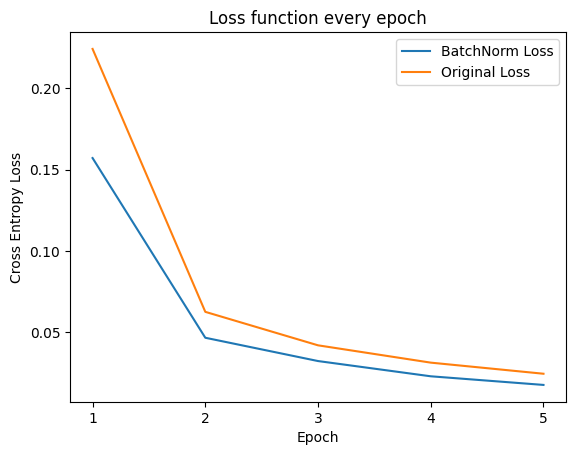

In [24]:
# Batch norm converge faster!!
plt.plot(range(1,len(epoch_loss2)+1), epoch_loss2, label="BatchNorm Loss")
plt.plot(range(1,len(epoch_loss)+1), epoch_loss, label="Original Loss")
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xticks(np.arange(1, 6, 1))
plt.title('Loss function every epoch')
plt.legend(loc='upper right')
plt.show()

In [25]:
# Evaluate the model on the test data
evaluate_model(model2, dataloaders['test'], device=device)

Accuracy on validation set: 99.13%


Since activations are normalized, the model should converge a little faster. This is because normalized activations are less likely to cause gradient explosion or vanishing gradients, and they make gradients more stable across the layers. This is also the reason why the loss function is lower as compare to the "original" ConvNet.
</br>
It seems to me that the training process has been a bit longer. This surprised me a little, but I guess it's because of the additional computation that we need to make to normalized the data.

# Visualizing Convolutional Neural Network

## POINT 2.1
Plot the conv1 layer filters. Do you observe interesting patterns?

https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html

In [28]:
model.eval()
# I can get the values of the weights as follow
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# We applied 32 filter 3x3 at conv1
print(f"\nShape of the filter: {model.state_dict()['conv1.0.weight'].cpu().numpy().shape}")

conv1.0.weight 	 torch.Size([32, 1, 3, 3])
conv1.0.bias 	 torch.Size([32])
conv2.0.weight 	 torch.Size([32, 32, 3, 3])
conv2.0.bias 	 torch.Size([32])
fc1.0.weight 	 torch.Size([500, 1568])
fc1.0.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])

Shape of the filter: (32, 1, 3, 3)


In [29]:
w_conv1 = model.state_dict()['conv1.0.weight'].cpu().numpy().reshape(32,3,3)
print(w_conv1.shape)

(32, 3, 3)


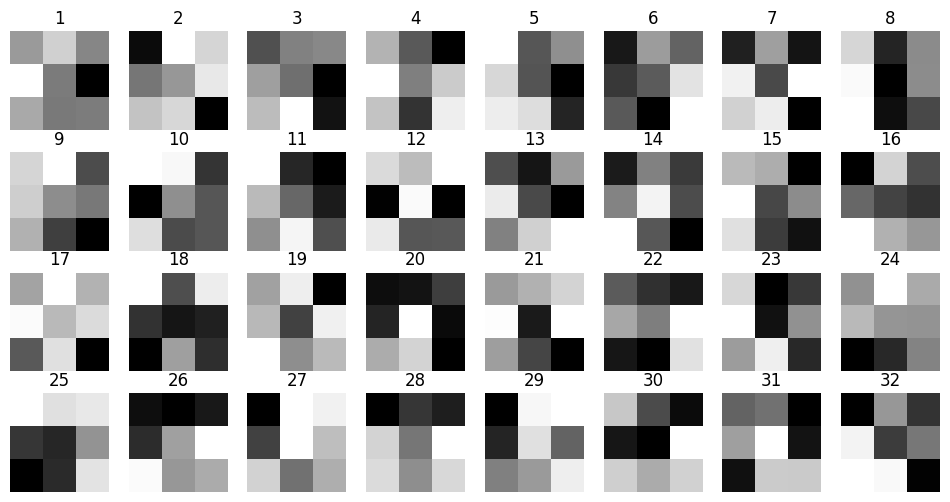

In [30]:
# So I am simply showing the weights of the first layer (the kernels)
fig = plt.figure(figsize=(12,6))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.title(f'{i}')
  plt.imshow(w_conv1[i-1],cmap='gray')
  plt.axis("off")

plt.show()

## POINT 2.2
Plot filters of a higher layer. Compare it with conv1 layer filters.

In [33]:
w_conv2 = model.state_dict()['conv2.0.weight'].cpu().numpy()

# We applied 32 filter 3x3 at conv2
# 32 depth because conv1 has 32 channels
print(f"Shape of the filter: {model.state_dict()['conv2.0.weight'].cpu().numpy().shape}")


Shape of the filter: (32, 32, 3, 3)


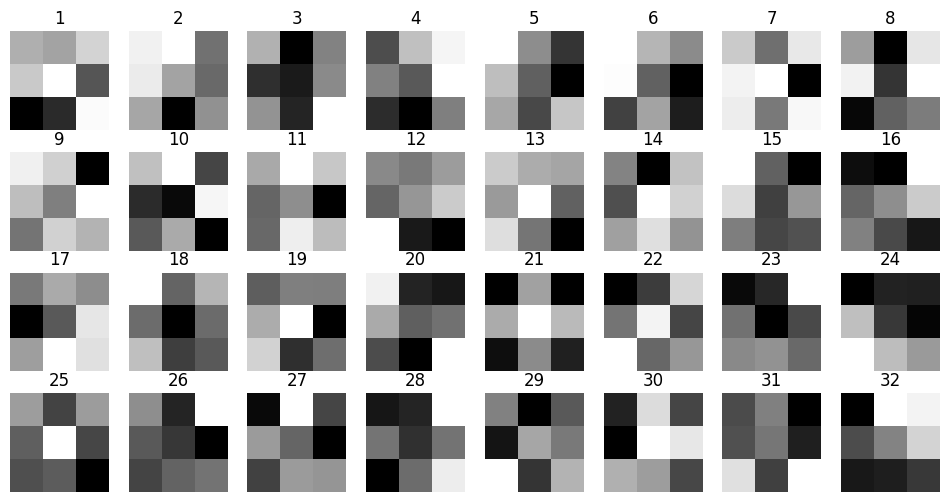

In [35]:
# So I am simply showing the weights of the first layer (the kernels)
fig = plt.figure(figsize=(12,6))
col,row = 8,4
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.title(f'{i}')
  plt.imshow(w_conv2[i-1,1],cmap='gray') # I plot just the first 32 filters (first channel)
  plt.axis("off")

plt.show()

From the plotted images it is difficult to conlude anything about what the filters are actually doing. Theoretically in the first layers they should search for "simpler" pattern, such as edges or color. As we proceed with the following layers they should search for more complex patterns. Besides the receptive field should increase (logically).
</br>
Anyway this ConvNet it is not very deep and the small filters applied do not give us enough information to understand what it is going on.

## POINT 2.3
Visualize the activations of the convolutional layers. What do you observe as you go deeper?



In [36]:
print(model2)

MyCNN_BN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=1568, out_features=500, bias=True)
  )
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


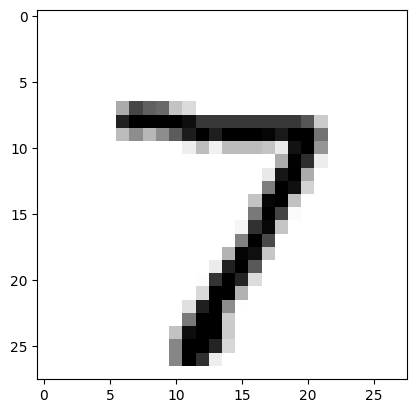

(32, 28, 28)
(32, 14, 14)


In [37]:
# Visualising first test image
for img,label in dataloaders['test']:
  test_image = img[0].to(device)
  test_label = label[0].to(device)
  plt.imshow(test_image.cpu().numpy().reshape(28,28), cmap=plt.cm.binary)
  plt.show()

# Then for the selected image I pass "manually" through the network to get the values of the activation functions
  layer1_out = model2.conv1(torch.reshape(test_image,(1,1,28,28)))
  layer1_out_np = layer1_out.cpu().detach().numpy().reshape(32,28,28)
  # Activation map after the first convolution layer
  print(layer1_out_np.shape) # see above
  layer2_out = model2.conv2(model.pool(layer1_out))
  layer2_out_np = layer2_out.cpu().detach().numpy().reshape(32,14,14)
  # Activation map after the second convolution layer
  print(layer2_out_np.shape) # see above

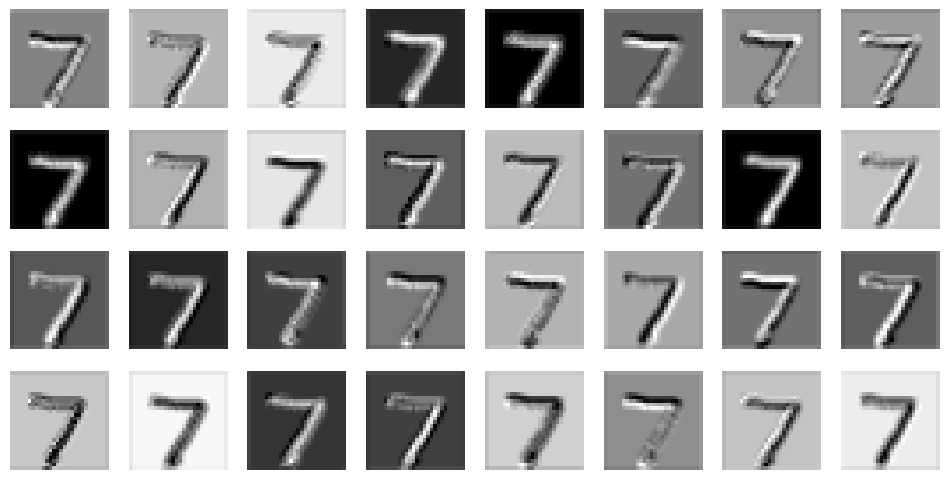

In [38]:
fig = plt.figure(figsize=(12,6))
col,row = 8,4

# Visualization of the 32 activation maps in the first convolutional layer
# The image is still pretty clear, which is expected since the convolution is applied
# directly to the raw pixels
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer1_out_np[i-1], cmap=plt.cm.binary)
  plt.axis("off")
plt.show()

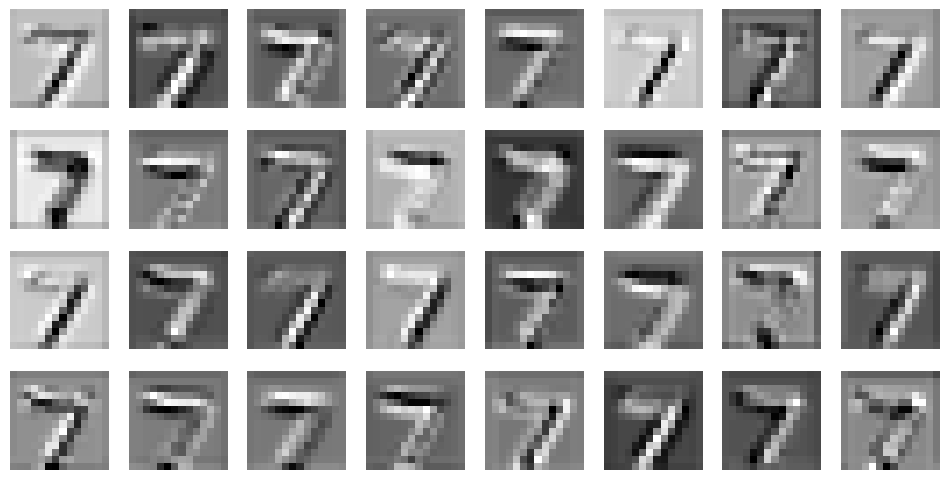

In [39]:
fig = plt.figure(figsize=(12,6))
col,row = 8,4

# Visualization of the 32 activation maps in the second convolutional layer
# The image is not that clear anymore:
# The more we go deep into the ConvNet the more the receptive field increase
# And the filters are applied on a higher-level representation of the image
for i in range(1,33):
  fig.add_subplot(row,col,i)
  plt.imshow(layer2_out_np[i-1], cmap=plt.cm.binary)
  plt.axis("off")
plt.show()

We can see that for the second convolutional layer it's more difficult to understand what is the input image. This is an expected behavior since deeper levels tend to analyze higer level features. In fact the input image had passed through one conv layer + max poolig before coming to the second conv layer. The input is still recognaziable because the conv net is not very deep.

## POINT 2.4
 Occluding parts of the image: Suppose that the network classifies an image of a digit successfully.

In [42]:
def occluded_image(input_image, location, patch_size=2):
  """
  Given the location returns the occluded image.
  :param:
  input_image: image to be occluded
  location: where to locate the patch
  patch_size: dimensions of the patch (it will be a square)

  :return:
  input_image_copy: occluded image
  """
  input_image_copy = input_image.copy()
  x = int(location[0])
  y = int(location[1])
  # Put a square of 0.5s on the location
  input_image_copy[x:x+patch_size, y:y+patch_size] = 0.5
  return input_image_copy

def get_heatmap(estimated_probabilities, patch_dim):
  """
  After the occlusion, it returns the heatmap. Ie: how the probabilities of
  choosing the right label change as we occluded the image.
  :param:
  estimated_probabilities: probability of choosing the right label for each patch location
  patch_dim: dimensions of the patch (it will be a square)

  :return:
  heatmap: heatmap of estimated_probabilities
  """
  estimated_probabilities = np.array(estimated_probabilities)
  # At each patch location I assign the probability
  map_size = int(28/patch_dim)
  heatmap = np.kron(estimated_probabilities.reshape(map_size, map_size), np.ones((patch_dim, patch_dim)))  # Upsample
  return heatmap

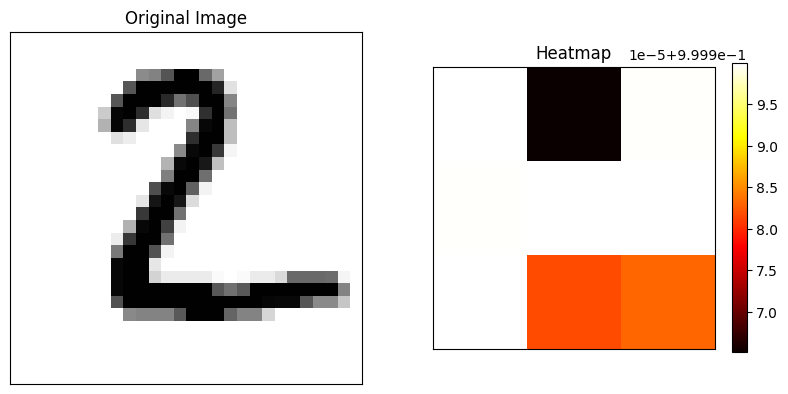

In [45]:
for img,label in dataloaders['test']:
  # get the first test image
  img_g = img[1].to(device)
  label_g = label[0].to(device)
  img_1_c = img_g.cpu().numpy().reshape(28,28)

  occluding_patch = []
  patch_dim = 8
  # Set all the possible location for the patch
  for x in range(0, 28-patch_dim, patch_dim):
    for y in range(0, 28-patch_dim, patch_dim):
      occluding_patch.append([x, y])

  estimated_probabilites = []
  tot_patches = int(28/patch_dim)*int(28/patch_dim)
  for j in range(tot_patches):
    # Get the occluded image and predict the value of the label
    # (run through the net)
    occ_1_img = occluded_image(img_1_c,occluding_patch[j],patch_dim)
    img_1_torch = torch.from_numpy(occ_1_img.reshape(1,1,28,28)).to(device)
    prediction_vect_gpu = model2(img_1_torch)

    prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy().squeeze()
    prediction_prob_vect = np.exp(prediction_vect_cpu)/np.sum(np.exp(prediction_vect_cpu))  # Softmax
    predicted_digit = np.argmax(prediction_prob_vect)
    prediction_probability = prediction_prob_vect[predicted_digit]

    estimated_probabilites.append(prediction_probability)

  # Get heatmap
  heatmap = get_heatmap(estimated_probabilites, patch_dim)

  # Plot image and heatmap side by side
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
  # Plot the original image
  axes[0].imshow(img_1_c, cmap=plt.cm.binary)
  axes[0].set_title(f"Original Image")
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  # Plot the heatmap
  heatmap_img = axes[1].imshow(heatmap, cmap='hot')
  axes[1].set_title("Heatmap")
  axes[1].set_xticks([])
  axes[1].set_yticks([])

  # Add a color scale
  fig.colorbar(heatmap_img, ax=axes[1], shrink=0.75)

  plt.show()

#  Adversarial Examples

###Helping functions

In [46]:
def softmax(x):
    """
    Compute the softmax of vector x
    """
    e_x = np.exp(np.squeeze(x)-np.max(x))
    return e_x / np.sum(e_x)

In [47]:
def normalize(x,eps=1e-8):
  """
  Normalize the image.
  """
  out = np.zeros_like(x)
  for i in range(x.shape[0]):
    high,low = np.amax(x[i]),np.amin(x[i])
    out[i] = (x[i]-low)/(high-low+eps)
  out = out*255
  out = out.astype(np.uint8)
  return out

## 3.1 Non-Targeted Attack

In [48]:
# load the pre-trained MNIST model with the highest accuracy
print(model2)

MyCNN_BN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=1568, out_features=500, bias=True)
  )
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [49]:
#  Do not change the trained weights in any of your operations: freeze the parameters
for child in model2.children():
  for param in child.parameters():
    param.requires_grad = False

In [50]:
# I'll save the final images here
img_grid = np.zeros((10,28,28))
# Cost function C=logits[target class]
C={}

for i in range(10):
  # Generating a noisy image
  noise = np.random.normal(loc=128,scale=0.05,size=(1,1,28,28)).astype(np.float32)
  noise = torch.from_numpy(noise)
  # requires_grad=True enables to update it using gradient descent
  X = torch.tensor(noise.type(torch.cuda.FloatTensor),requires_grad=True, device='cuda')
  # Apply the optimizer on X
  optimizer = torch.optim.SGD([X],lr=0.0001)
  C[str(i)] = []
  for j in range(2000): # 2000 updates of the pixels
    model2.zero_grad()
    # getting the logits (before softmax)
    out_var = model2(X)
    # In loss we usually give what we want to minimize
    # Therefore since we want to maximize the activation of the target class i
    # It is the same as minizing the same function in negative
    # eg: minimize -out_var[0][i], it’s equivalent to maximizing out_var[0][i]
    loss = -out_var[0][i]

    # Compute the gradients of the loss with respect to X
    loss.backward()
    # Optimization step (fix X so to maximize the logit)
    optimizer.step()

    # Since the loss is basically -logit this is the function C=logits[target class]
    # We also save the cost function to plot it
    C[str(i)].append(loss.item())
  n_img = X.cpu().detach().numpy()
  # Normalize and reshape the image
  img_grid[i,:,:] = normalize(n_img)

<ipython-input-50-bf52486c3bb4>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(noise.type(torch.cuda.FloatTensor),requires_grad=True, device='cuda')


1. Show the generated image for each of the MNIST classes.

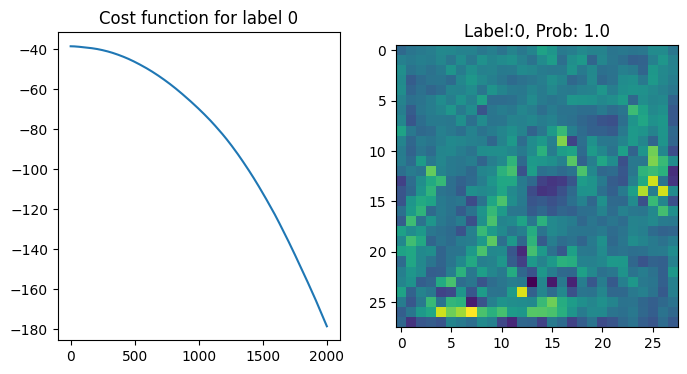

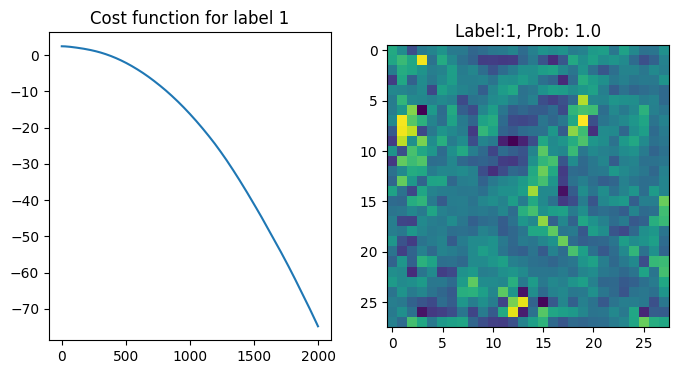

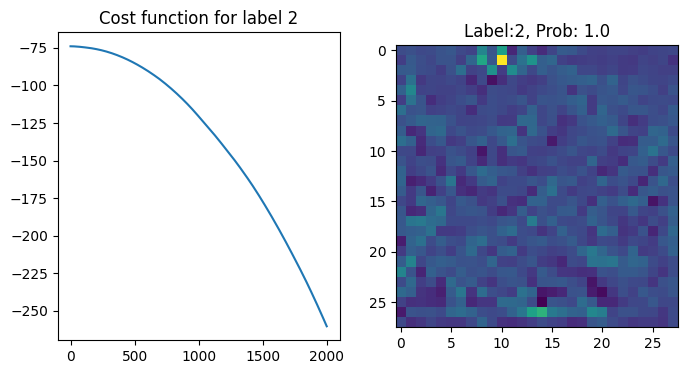

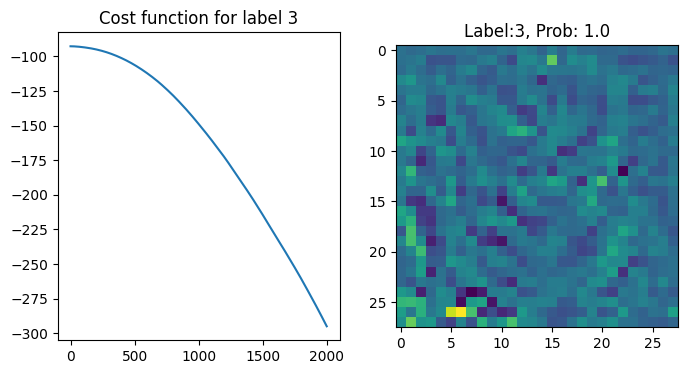

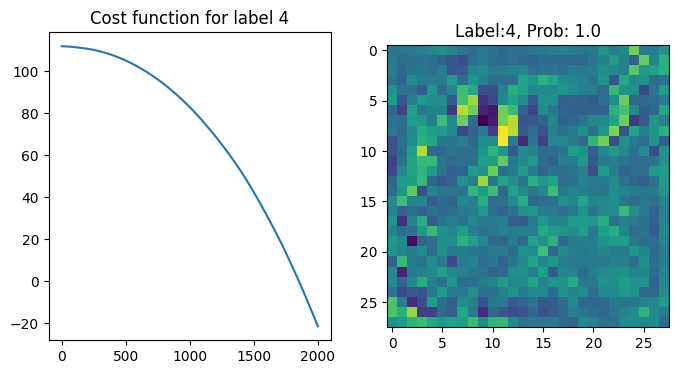

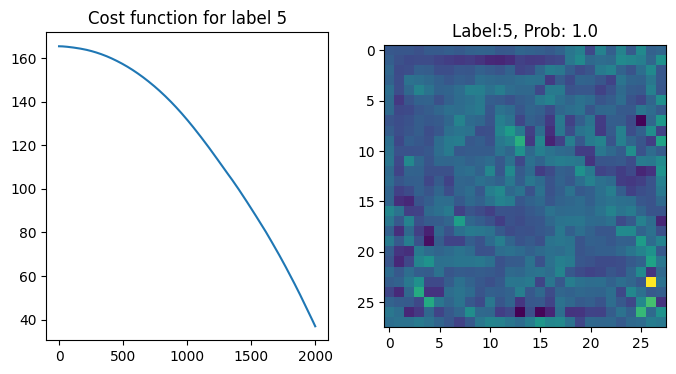

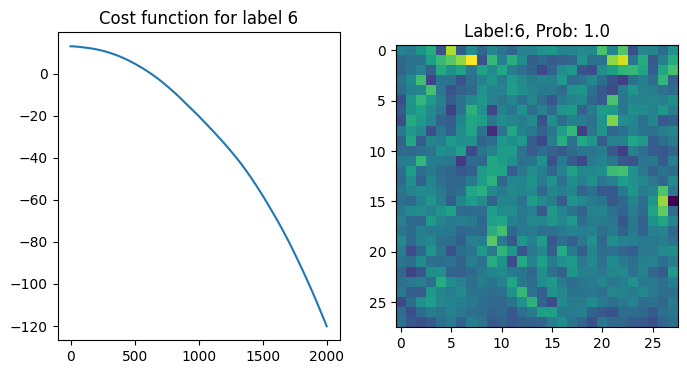

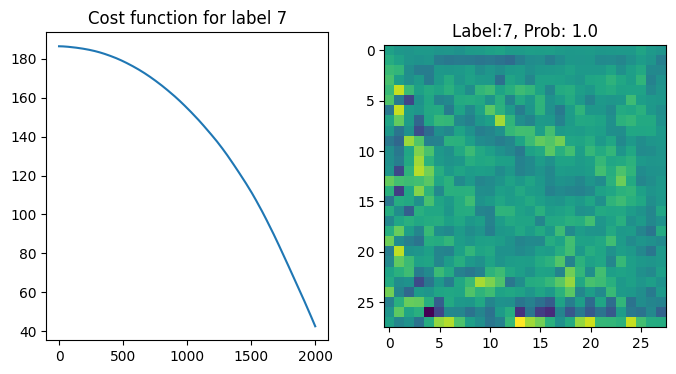

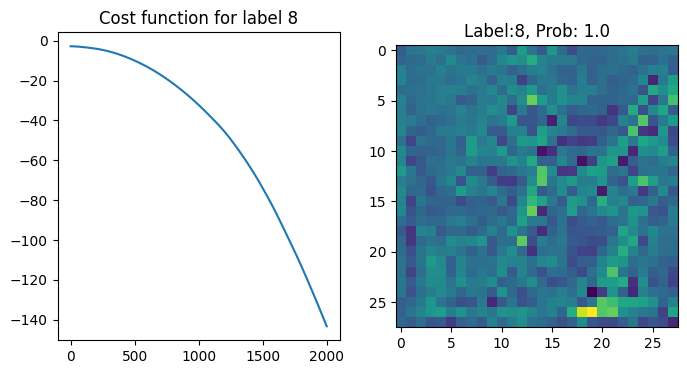

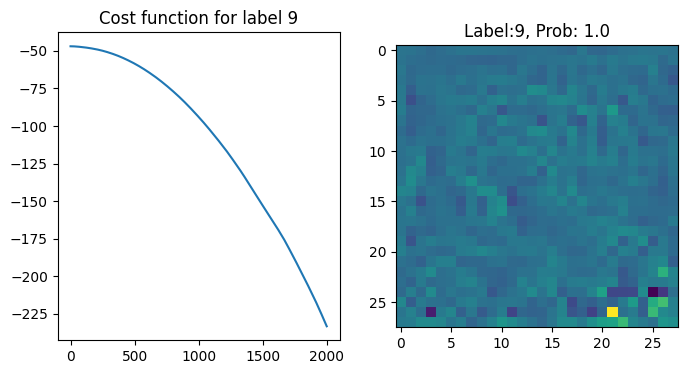

In [51]:
for i in range(10):
  fig = plt.figure(figsize=(8,4))
  fig.tight_layout()
  col,row = 2,1

  # Need to reshape the images so I can predict the class
  # I expect the confidence to be max since we modify the image with this goal
  in_image = torch.reshape(torch.from_numpy(img_grid[i].astype(np.float32)),(1,1,28,28)).to(device)
  #   print(in_image.size)

  prediction_vect_gpu = model2(in_image)
  prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy()

  # Getting the class prediction and the probability
  prediction_prob_vect = softmax(prediction_vect_cpu)
  predicted_digit = np.argmax(prediction_prob_vect)
  prediction_probability = prediction_prob_vect[predicted_digit]

  # Plot the image and the cost function
  a = fig.add_subplot(row,col,1 )
  a.title.set_text(f'Cost function for label {i}')
  a.plot(np.arange(0,len(C[str(i)])),np.array(C[str(i)]))

  b= fig.add_subplot(row,col,2)
  b.title.set_text(f'Label:{predicted_digit}, Prob: {prediction_probability}')
  plt.imshow(img_grid[i])
plt.show()

### Questions
<b> 2. Is the network always predicting target class with high confidence for the generated images? </b>
Yes, because we have generated the image my fixing that prediction to be max.
</br>
<b> 3. Do the generated images look like a number? If not, can you think of some reason? </b>
Not really much. The reason is because, even though the images are really small, the pixel matrices can have a very very wide number of values, in particular $R^{W}$x$R^{H}$ where W and H are the image dimensions! This means that only a very few matrices look like a image to the naked eye. But many other raw random pixels can be seen by the net as real values.
</br>
<b> 4. Plot the cost function. Is it increasing or decreasing? </b>
Since I define the cost function as the negative of the logit, it's trying to minimize this value, therefore it is decreasing.

## 3.2 Targeted Attack
Consider target image as an image of 2 and target class as 5. Hence, for this, change the cost function to:
</br>
C = logits[target class] − β × MSE(generated image,target image)
C = max the probability of the target class + max the similarity to target image
</br>
X = X + step_size×d

In [52]:
# I first want to find a "part" of the dataset with all unique classes
# So I can fool the Net for each class as requested
for images,labels in dataloaders['test']:
  print(torch.unique(labels[9705:9715]))
for k in range(9705,9715):
  print(k, labels[k])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
9705 tensor(1)
9706 tensor(2)
9707 tensor(3)
9708 tensor(4)
9709 tensor(5)
9710 tensor(6)
9711 tensor(7)
9712 tensor(8)
9713 tensor(9)
9714 tensor(0)


<ipython-input-58-75b845b37ed1>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generated_image = torch.tensor(generated_image.type(torch.cuda.FloatTensor),requires_grad=True,device='cuda')
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


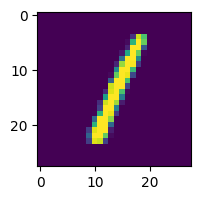

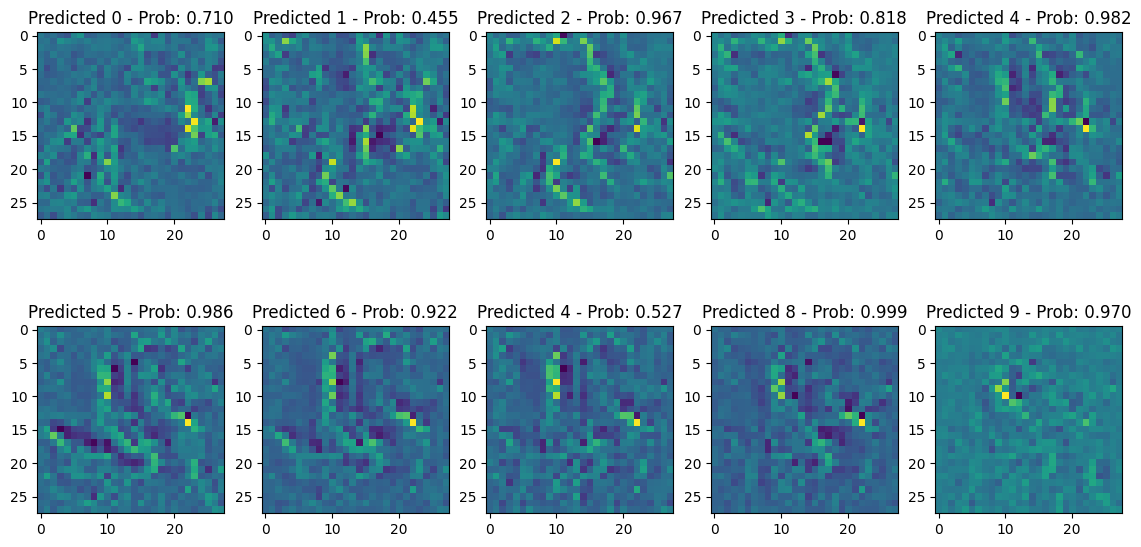

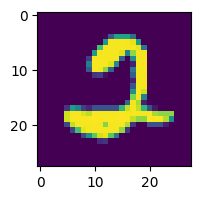

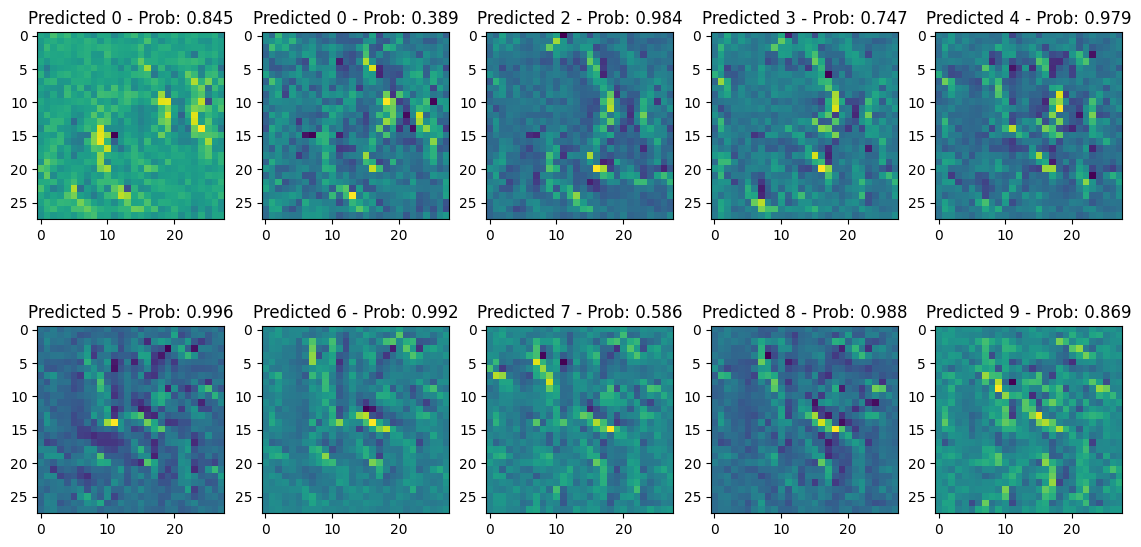

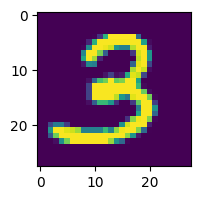

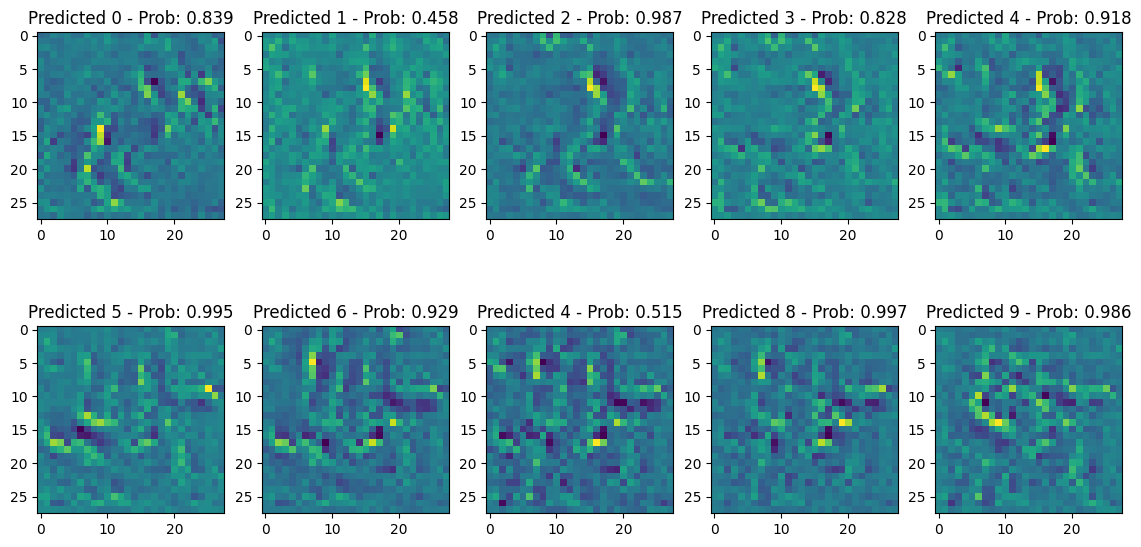

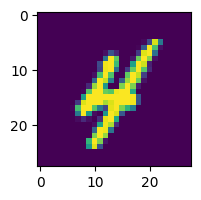

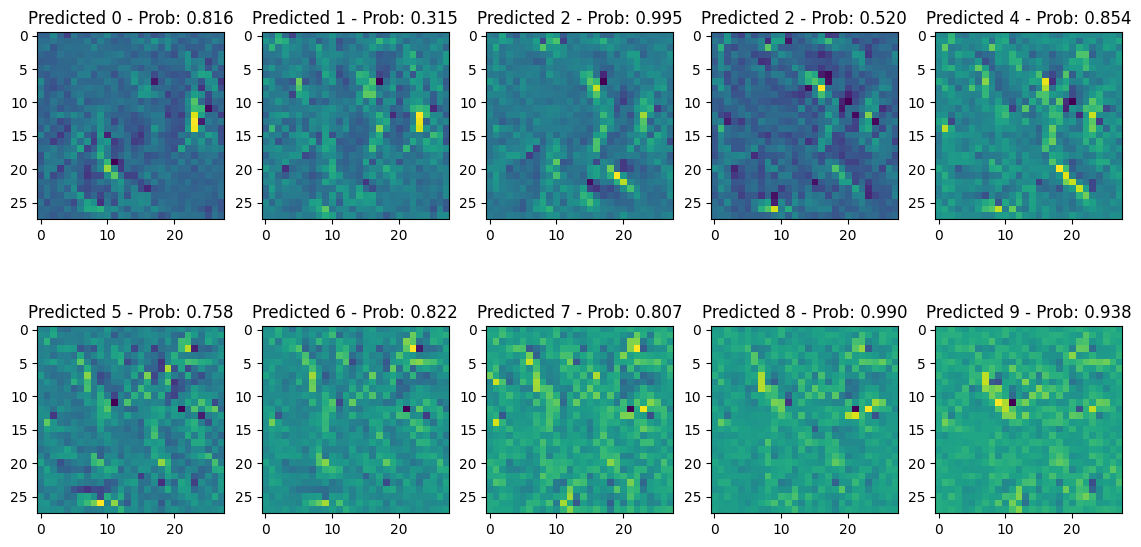

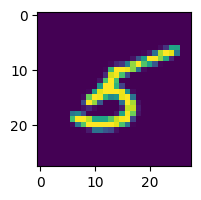

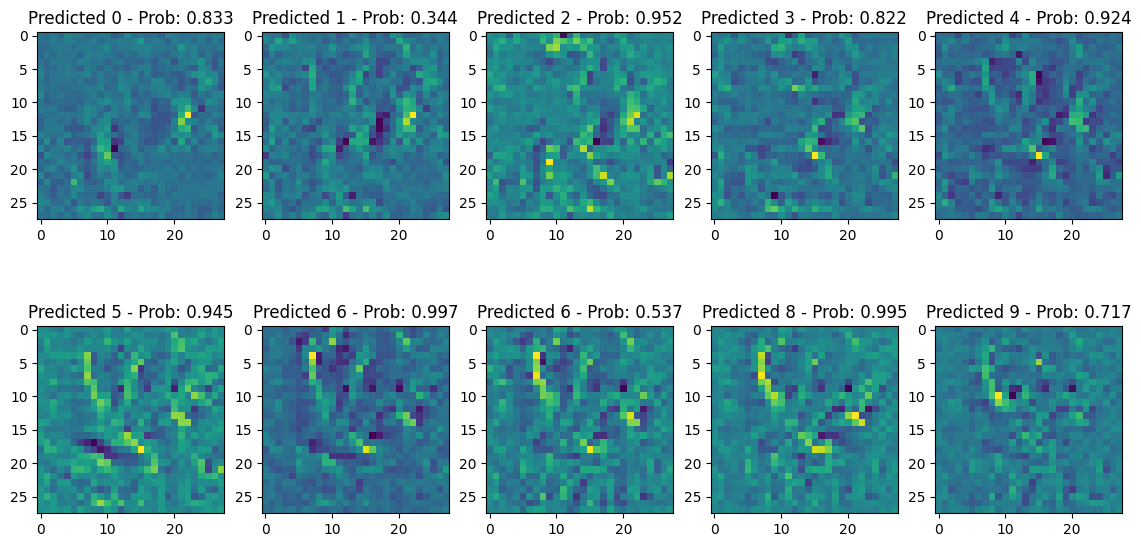

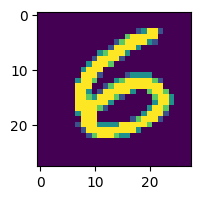

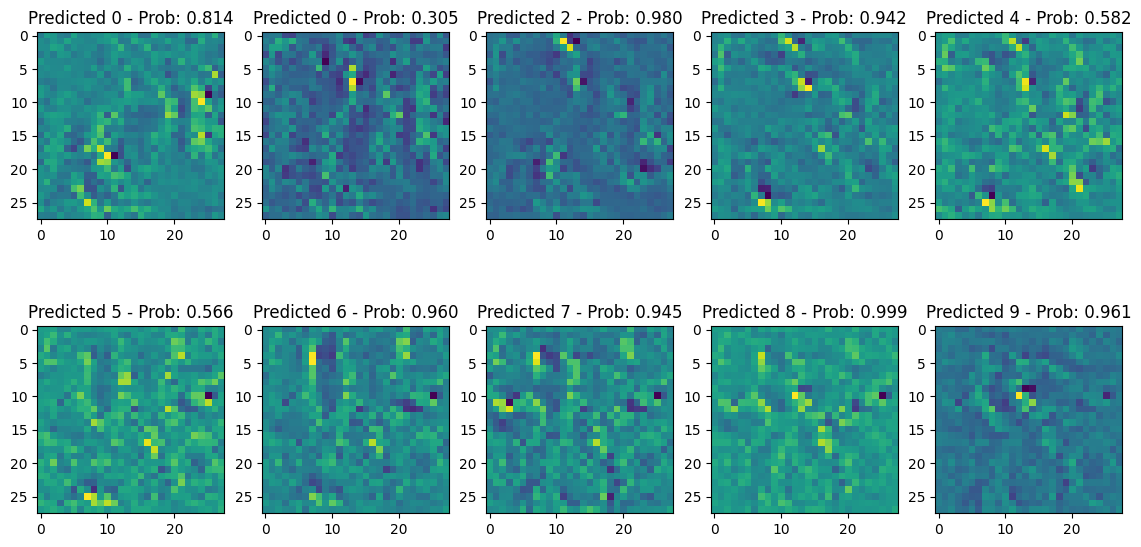

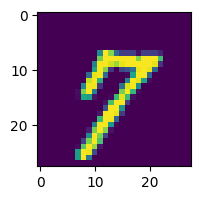

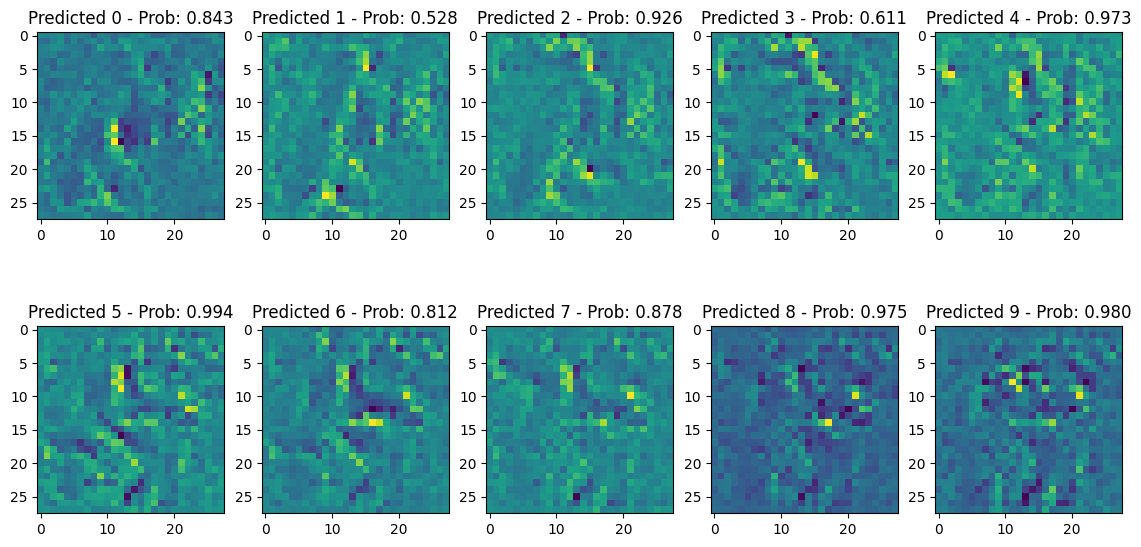

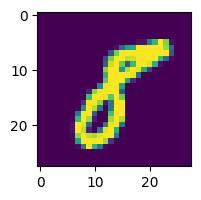

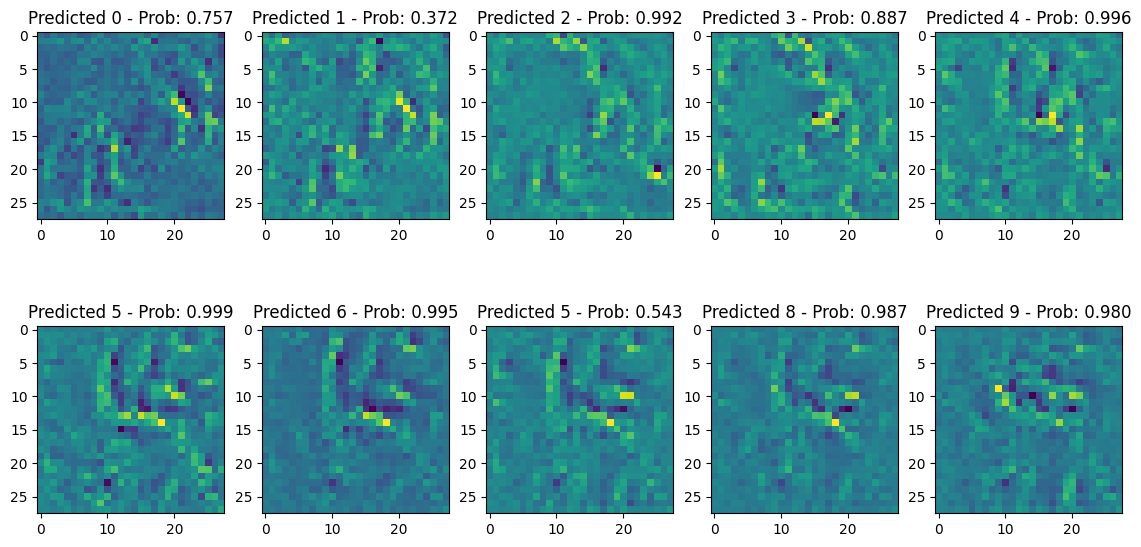

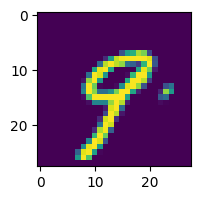

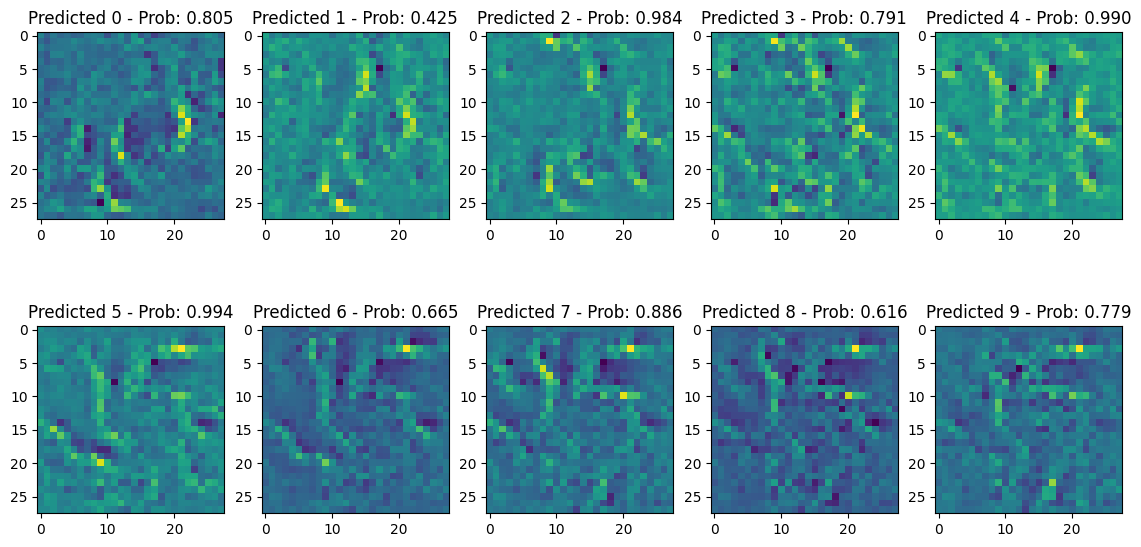

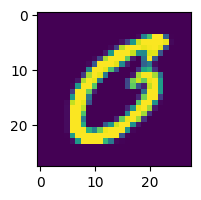

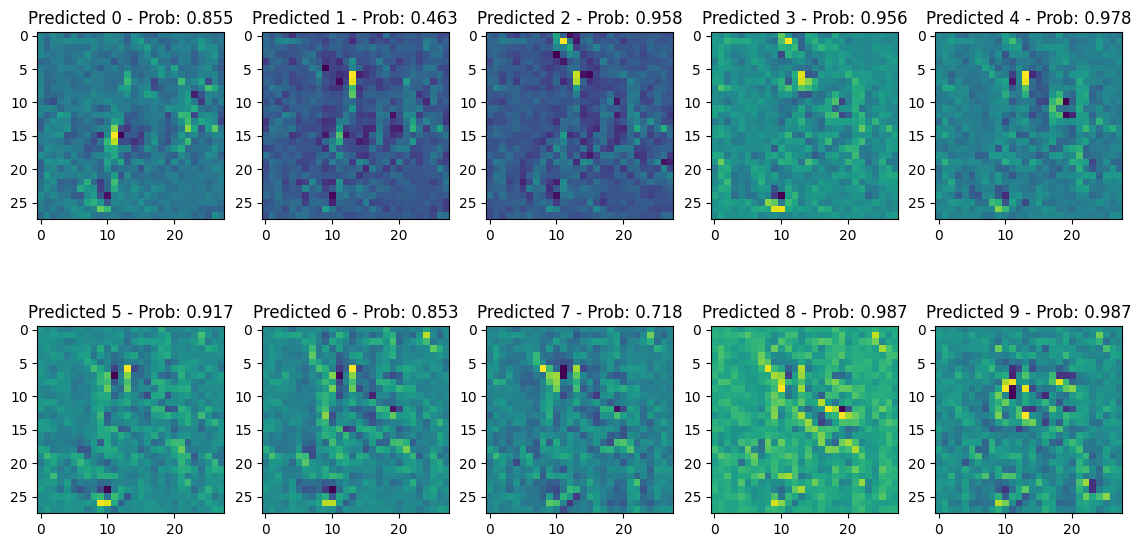

In [58]:
for images,labels in dataloaders['test']:
  for k in range(9705,9715):
    beta = 0.0001
    col,row = 5,2

    # Get the target image: what I want the image to resemble
    target_image = images[k].to(device)
    # print(labels[k]) # test
    fig = plt.figure(figsize=(2,2))
    plt.imshow(torch.squeeze(images[k]).cpu().numpy())
    fig = plt.figure(figsize=(14,7))
    fig.tight_layout()

    # This is my objective image: the image that I want to generate
    # Normalized image
    generated_image = np.random.normal(loc=0.5,scale=0.05,size=(1,1,28,28)).astype(np.float32)
    # Create a tensor
    generated_image = torch.from_numpy(generated_image)
    generated_image = generated_image.to(device)

    # Convert the generated image into a pyTorch tensor with grad tracking
    generated_image = torch.tensor(generated_image.type(torch.cuda.FloatTensor),requires_grad=True,device='cuda')
    # Stochastic Gradient Descent updates every iteration of a sample (not every batch or full dataset)
    # We want to optimize the generated image (usually the parameters)!!
    step_size = 0.001
    # img_var=img_var+step_size×d
    optimizer = torch.optim.SGD([generated_image],lr=step_size)
    for target_class in range(10):
      for iteration in range(3000): # Training iterations
        optimizer.zero_grad()
        # Run the generated image though the Net
        out_var=model2(generated_image)
        # Set the loss function (see above)
        MSE=nn.MSELoss()
        # C = logits[target_class] − beta × MSE(generated_image,target_image)
        # as for the Non-Targeted attack max logit = min -logit
        # besides in this case we also want to maximize the mse
        loss = -1*out_var[0][target_class]+beta*MSE(generated_image,target_image)
        loss.backward()
        optimizer.step()

      # Bring back the image to Numpy for representation
      generated_image_cpu = generated_image.cpu().detach().numpy()
      generated_image_cpu=normalize(generated_image_cpu)

      # Now I normally run the generated image through the net
      generated_prediction = model2(generated_image)
      generated_prediction = generated_prediction.detach().cpu().numpy()

      # Getting the probability
      generated_prediction_prob = np.exp(generated_prediction)/np.sum(np.exp(generated_prediction))  # Softmax
      predicted_label = np.argmax(generated_prediction_prob)
      prediction_probability = generated_prediction_prob[0][predicted_label]
      # print(f"predicted: {predicted_label}")
      # print(generated_prediction_prob)

      a = fig.add_subplot(row,col,target_class+1)
      a.title.set_text(f'Predicted {predicted_label} - Prob: {prediction_probability:.3f}')
      plt.imshow(np.squeeze(generated_image_cpu))

https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_simple_CNN.py

http://www.cse.iitm.ac.in/~miteshk/CS6910.html

https://cs231n.github.io/
https://github.com/bethgelab/foolbox